Based on the methods developed in [loan_eda_modeling.ipynb](loan_eda_modeling.ipynb), in this notebook, I implement a pipeline to train a model and make predictions using two classes. Note that here I use all the loans that were granted as the training set, and use all the loans that were not granted as the test set (pretending they are new requested loans for which predictions are needed).

**TODO**:
- add model explainability?

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
df_loan = pd.read_csv('data/loan_table.csv')
df_borrower = pd.read_csv('data/borrower_table.csv')
df = df_loan.merge(df_borrower, on='loan_id')

In [3]:
df.shape

(101100, 16)

In [4]:
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [5]:
df_train = df[df['loan_granted'] == 1].drop(['loan_granted'], axis=1).reset_index(drop=True)  
df_test = df[df['loan_granted'] == 0].drop(['loan_granted'], axis=1).reset_index(drop=True)

### Define Data class

In [6]:
class Data(object):
    def __init__(self, df_raw, target_col=None, id_col=None, drop_cols=None, one_hot=False, 
                 trainset=None):
        """
        Parameters
        ----------
        df_raw : pandas.core.frame.DataFrame
            The input dataframe that will be processed 
        target_col : str
            The column for the target variable (default is None)
        id_col : list
            The column for loan id (default is None)
        drop_cols : list
            The columns that will be dropped, in addition to granted_col (default is None)
        one_hot : bool, optional
            A flag used to decide whether to use one-hot encoding or label encoding (default is False)
        trainset : __main__.Data
            The Data object of the training set; when it is passed, the four parameters above 
            are ignored (default is None)
        """
        if trainset:
            self.target_col = trainset.target_col
            self.id_col = trainset.id_col
            self.drop_cols = trainset.drop_cols
            self.one_hot = trainset.one_hot
            self.label_encoders = trainset.label_encoders
            self.standard_scaler = trainset.standard_scaler
        else:
            self.target_col = target_col
            self.id_col = id_col
            self.drop_cols = drop_cols
            self.one_hot = one_hot
            self.label_encoders = {}
            self.standard_scaler = None
        self.num_cols = []
        self.cat_cols = []
        self.feature_cols = []
        self.df = self._create_df(df_raw)
        
    def onehot_encode_df(self, df, cols):
        """perform one-hot encoding on the specified columns"""
        return pd.get_dummies(df, columns=cols)
    
    def label_encode_df(self, df, cols):
        """create one label encoder for each of columns specified"""
        for col in cols:
            if col in self.label_encoders:
                # if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
                
    def standard_scaler_df(self, df, cols):
        """perform standardization on the specified columns"""
        
        if self.standard_scaler:
            df[cols] = self.standard_scaler.transform(df[cols])
        else:
            scaler = StandardScaler()
            df[cols] = scaler.fit_transform(df[cols])
            self.standard_scaler = scaler
        return df

    def _create_df(self, df_raw):
        """create the processed dataframe"""
        df = self._preprocess(df_raw, self.drop_cols)
        self._feature_types(df, self.num_cols, self.cat_cols)
        if self.one_hot:
            df = self.onehot_encode_df(df, self.cat_cols)
        else:
            self.label_encode_df(df, self.cat_cols)

        self._get_feature_cols(df, self.feature_cols)
        if self.one_hot:
            df = self.standard_scaler_df(df, self.feature_cols)
        return df

    def _preprocess(self, df, drop_cols):
        """ 
        drop the specified useless columns, rename some columns, and then process the data
        based on the methodss in another notebook "loan_eda_modeling.ipynb"
        """
        df = df.drop(drop_cols, axis=1)
        df = self._rename_columns(df)
        df = self._clean(df)
        return df
    
    def _rename_columns(self, df):
        """rename some columns whose names are too long"""
        rename = {
            'fully_repaid_previous_loans': 'previous_repaid', 
            'currently_repaying_other_loans': 'repaying',
            'total_credit_card_limit': 'credit_limit', 
            'avg_percentage_credit_card_limit_used_last_year': 'limit_used'
        }
        return df.rename(columns=rename)
    
    def _clean(self, df):
        """impute missing values, combine saving_amount and checking_amount"""
        if df.limit_used.isnull().sum() > 0:
            df.limit_used.fillna(0, inplace=True)
        if df.previous_repaid.isnull().sum() > 0:
            df.previous_repaid.fillna(-1, inplace=True)
        if df.repaying.isnull().sum() > 0:
            df.repaying.fillna(-1, inplace=True)
        df.previous_repaid.replace({0: 'No', 1: 'Yes', -1: 'NA'}, inplace=True)
        df.repaying.replace({0: 'No', 1: 'Yes', -1: 'NA'}, inplace=True)
        df['savings'] =  df.saving_amount + df.checking_amount
        df = df.drop(['saving_amount', 'checking_amount'], axis=1)
        return df
    
    def _feature_types(self, df, num_cols, cat_cols):
        """find out which (untransformed) columns are numerical and which are categorical"""
        for col in df.columns:
            if df[col].dtype.name == 'object':
                cat_cols.append(col)
            else:
                num_cols.append(col)
                                
    def _label_encode(self, df, col, le=None):
        """perform label encoding for the specified column"""
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le
            
    def _get_feature_cols(self, df, feature_cols):
        """find out which (transformed) columns are the features"""
        for col in df.columns:
            if col != self.id_col and col != self.target_col:
                feature_cols.append(col)

### Define Model class

In [7]:
class Model(object):
    def __init__(self):
        self.model = None
        self.best_model = None
        self.predictions = None
        self.cv_score = 0
        self.trainset = None

    def train(self, data, model="RF", scoring="roc_auc", k=3, tune=True):
        """train the specified model and get cross-validation score
                
        Parameters
        ----------
        data : __main__.Data
            The Data object
        model : str
            The model type, "RF" or "LR" (default is "RF")
        scoring : str
            The evalution metric (default is "roc_auc")
            See https://scikit-learn.org/stable/modules/model_evaluation.html
        k : int
            The number of folds for cross validation (default is 3)
        tune : bool
            Whether to run a grid search to tune the model (default is True)
        """
        self.trainset = data
        if tune:
            self.best_model = self._grid_search(self.trainset, model, scoring, k)
        else:
            self.best_model = self._get_model(self.trainset, model, scoring, k)
        self.model = model
            
    def _grid_search(self, data, model, scoring, k):
        """run a grid search with cross validation to fine-tune the model"""
        features = data.df[data.feature_cols]
        target = data.df[data.target_col]
        if model == "LR":
            clf = LogisticRegression()
            parameters = {"C": 0.001*10**(np.arange(0, 1.01, 0.01)*3)}
        elif model == "RF":
            clf = RandomForestClassifier(n_estimators=50, random_state=0)
            parameters = {
                "max_features": [2, 3, 4, 5], 
                "min_samples_split": [2, 3, 4, 5], 
                "max_depth": range(10, 15)}
        else:
            raise ValueError('model has to be "LR" or "RF"!')
        grid_search = GridSearchCV(estimator=clf, cv=k, param_grid=parameters, scoring=scoring, n_jobs=-1)
        grid_search = grid_search.fit(features, target)
        self.cv_score = grid_search.best_score_
        return grid_search.best_estimator_
    
    def _get_model(self, data, model, scoring, k):
        """use pre-selected hyperparameters for the model and compute cross-validation score"""
        features = data.df[data.feature_cols]
        target = data.df[data.target_col]
        if model == "LR":
            clf = LogisticRegression(C=0.0224)
        elif model == "RF":
            clf = RandomForestClassifier(n_estimators=50, 
                                         max_features=2, 
                                         min_samples_split=3, 
                                         max_depth=12, 
                                         random_state=0)
        else:
            raise ValueError('model has to be "LR" or "RF"!')
        self.cv_score = self._cross_validate(clf, features, target, scoring, k)
        clf.fit(features, target)
        return clf
    
    def predict(self, data):
        """use the trained model to make predictions for a given dataset"""
        features = data.df[data.feature_cols]
        self.predictions = self.best_model.predict_proba(features)[:, 1]
        return self.predictions
    
    def _cross_validate(self, model, features, target, scoring, k):
        """compute cross-validation score using the training data"""
        return cross_val_score(model, features, target, cv=k, n_jobs=-1, scoring=scoring).mean()
        
    def _get_feature_importance(self, model, cols):
        """retrieves and sorts the feature importances"""
        imp = model.feature_importances_ 
        sorted_importances = sorted(zip(imp, cols), reverse=True)
        importances = [i for i, _ in sorted_importances]
        feature = [i for _, i in sorted_importances]
        return pd.DataFrame({'importances': importances}, index=feature)

    def _get_coefficients(self, model, cols):
        """retrieves and sorts the coefficients of logistic regression"""
        coefs = model.coef_.reshape(-1)      
        sorted_coefficients = sorted(zip(coefs, cols), key = lambda x: -abs(x[0]))
        coefficients = [i for i, _ in sorted_coefficients]
        feature = [i for _, i in sorted_coefficients]
        return pd.DataFrame({'coefficients': coefficients}, index=feature)

    def print_summary(self):
        """generate summary of the model, cross-validation score, and feature importance"""
        print("--- Model Summaries ---\n")
        print(self.best_model)
        print("\nCross-validation Score: " + str(self.cv_score))
        if self.model == "RF":
            print("\nFeature Importances:\n")
            feature_importances = self._get_feature_importance(self.best_model, self.trainset.feature_cols)
            print(feature_importances)
            feature_importances.plot.bar()
            plt.show()
        if self.model == "LR":
            print("\nCoefficients:\n")
            coefficients = self._get_coefficients(self.best_model, self.trainset.feature_cols)
            print(coefficients)
            coefficients.plot.bar()
            plt.show()

### Logistic Regression Example

##### Define parameters

In [8]:
target_col = 'loan_repaid'
id_col = 'loan_id'
drop_cols = ['date', 'is_first_loan', 'age', 'is_employed']
one_hot = True

##### Create the Data objects

In [9]:
data_train = Data(df_train, target_col, id_col, drop_cols, one_hot)
data_test = Data(df_test, trainset=data_train)

In [10]:
data_train.df.head()

,loan_id,loan_repaid,credit_limit,limit_used,yearly_salary,dependent_number,savings,loan_purpose_business,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,previous_repaid_NA,previous_repaid_No,previous_repaid_Yes,repaying_NA,repaying_No,repaying_Yes
0,580653,1.0,0.441572,-0.833087,-0.825599,0.094439,0.202610,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775
1,172419,0.0,-0.824183,0.365419,0.341022,0.094439,-0.267811,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
2,780070,1.0,1.656696,-1.931717,1.341861,-0.668534,1.052748,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775
3,303138,0.0,-0.115360,1.663801,-0.874720,-0.668534,-1.047938,-0.540464,2.268595,-0.567673,-0.534952,-0.411855,-1.086032,4.620799,-0.840681,-1.086032,-0.689494,2.513985
4,91475,1.0,-0.317881,-0.183896,-1.058924,-1.050021,0.038100,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,1.450339,-0.397775


In [11]:
data_test.df.head()

,loan_id,loan_repaid,credit_limit,limit_used,yearly_salary,dependent_number,savings,loan_purpose_business,loan_purpose_emergency_funds,loan_purpose_home,loan_purpose_investment,loan_purpose_other,previous_repaid_NA,previous_repaid_No,previous_repaid_Yes,repaying_NA,repaying_No,repaying_Yes
0,19454,NaN,2.061738,0.515233,0.979594,1.238899,0.777531,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
1,496811,NaN,0.390942,-0.833087,-1.795737,0.475926,0.142255,-0.540464,-0.440801,-0.567673,1.869328,-0.411855,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
2,929493,NaN,-2.292458,-3.429849,-0.168607,0.094439,-0.561997,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
3,77085,NaN,-0.773553,0.665046,-1.795737,-0.287048,-0.422319,-0.540464,-0.440801,-0.567673,-0.534952,2.428041,0.920783,-0.216413,-0.840681,0.920783,-0.689494,-0.397775
4,422392,NaN,-1.786156,2.013365,-1.795737,-0.668534,-1.372473,1.850261,-0.440801,-0.567673,-0.534952,-0.411855,-1.086032,-0.216413,1.189512,-1.086032,-0.689494,2.513985


In [12]:
data_train.feature_cols

['credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings',
 'loan_purpose_business',
 'loan_purpose_emergency_funds',
 'loan_purpose_home',
 'loan_purpose_investment',
 'loan_purpose_other',
 'previous_repaid_NA',
 'previous_repaid_No',
 'previous_repaid_Yes',
 'repaying_NA',
 'repaying_No',
 'repaying_Yes']

In [13]:
data_test.feature_cols

['credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings',
 'loan_purpose_business',
 'loan_purpose_emergency_funds',
 'loan_purpose_home',
 'loan_purpose_investment',
 'loan_purpose_other',
 'previous_repaid_NA',
 'previous_repaid_No',
 'previous_repaid_Yes',
 'repaying_NA',
 'repaying_No',
 'repaying_Yes']

##### Create a Model object, train the Logistic Regression and make predictions

In [14]:
model = Model()
model.train(data_train, model="LR", scoring='roc_auc', k=3, tune=False)

In [15]:
model.predict(data_test)

array([0.99917242, 0.78636025, 0.24080582, ..., 0.00175946, 0.00384931,
       0.09246106])

--- Model Summaries ---

LogisticRegression(C=0.0224, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Cross-validation Score: 0.9629836750766384

Coefficients:

                              coefficients
savings                           2.809914
yearly_salary                     1.097169
credit_limit                      1.034950
repaying_Yes                     -0.493231
limit_used                       -0.424156
repaying_No                       0.351724
dependent_number                 -0.254687
loan_purpose_emergency_funds     -0.226838
loan_purpose_business             0.146685
loan_purpose_other               -0.131474
loan_purpose_investment           0.127179
previous_repaid_No               -0.050359
loan_purpose_home           

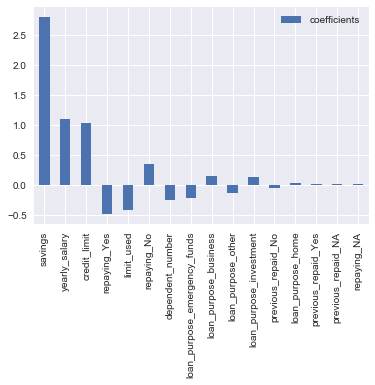

In [16]:
model.print_summary()

### Random Forest Example

##### Define parameters

In [17]:
# same as above except one-hot encoding is not needed this time
one_hot = False

##### Create the Data objects

In [18]:
data_train = Data(df_train, target_col, id_col, drop_cols, one_hot)
data_test = Data(df_test, trainset=data_train)

In [19]:
data_train.df.head()

,loan_id,loan_purpose,loan_repaid,previous_repaid,repaying,credit_limit,limit_used,yearly_salary,dependent_number,savings
0,580653,4,1.0,2,1,5400,0.52,15800,4,6109
1,172419,0,0.0,0,0,2900,0.76,34800,4,4745
2,780070,0,1.0,2,1,7800,0.30,51100,2,8574
3,303138,1,0.0,1,2,4300,1.02,15000,2,2483
4,91475,3,1.0,2,1,3900,0.65,12000,1,5632


In [20]:
data_test.df.head()

,loan_id,loan_purpose,loan_repaid,previous_repaid,repaying,credit_limit,limit_used,yearly_salary,dependent_number,savings
0,19454,3,NaN,0,0,8600,0.79,45200,7,7776
1,496811,3,NaN,0,0,5300,0.52,0,5,5934
2,929493,4,NaN,0,0,0,0.00,26500,4,3892
3,77085,4,NaN,0,0,3000,0.82,0,3,4297
4,422392,0,NaN,2,2,1000,1.09,0,2,1542


In [21]:
data_train.feature_cols

['loan_purpose',
 'previous_repaid',
 'repaying',
 'credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings']

In [22]:
data_test.feature_cols

['loan_purpose',
 'previous_repaid',
 'repaying',
 'credit_limit',
 'limit_used',
 'yearly_salary',
 'dependent_number',
 'savings']

##### Create a Model object, train the Random Forest and make predictions

In [23]:
model = Model()
model.train(data_train, model="RF", scoring='roc_auc', k=3, tune=False)

In [24]:
model.predict(data_test)

array([0.99908136, 0.94474787, 0.09549128, ..., 0.01531307, 0.01192037,
       0.13131276])

--- Model Summaries ---

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Cross-validation Score: 0.9656627263839587

Feature Importances:

                  importances
savings              0.559866
yearly_salary        0.161415
credit_limit         0.133414
repaying             0.066722
limit_used           0.039876
dependent_number     0.017784
loan_purpose         0.013507
previous_repaid      0.007415


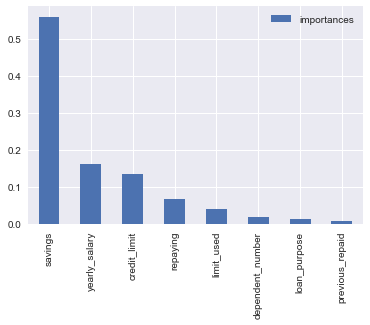

In [25]:
model.print_summary()